In [84]:
import keras.backend as K
import tensorflow as tf
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Input, Dense, concatenate, Lambda
from keras.models import Model
from keras.utils import plot_model
import keras
import numpy as np

In [87]:
img_size = 139
channel = 3
batch_size = 32
triplets_selection_batch_size = 1800
epochs = 1
embedding_size = 128
alpha = 0.2
num_train_samples = 256000
num_lfw_valid_samples = 2185

In [85]:
def create_model():
    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(img_size, img_size, channel), pooling='avg')
    
    image_input = base_model.input
    x = base_model.output
    out = Dense(embedding_size)(x)
    image_embedder = Model(image_input, out)

    input_a = Input((img_size, img_size, channel), name='anchor')
    input_p = Input((img_size, img_size, channel), name='positive')
    input_n = Input((img_size, img_size, channel), name='negative')

    normalize = Lambda(lambda x: K.l2_normalize(x, axis=-1), name='normalize')

    x = image_embedder(input_a)
    output_a = normalize(x)
    x = image_embedder(input_p)
    output_p = normalize(x)
    x = image_embedder(input_n)
    output_n = normalize(x)

    merged_vector = concatenate([output_a, output_p, output_n], axis=-1)
    model = Model(inputs=[input_a, input_p, input_n], outputs=merged_vector)
    
    return model

In [86]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          54533472    anchor[0][0]                     
                                                                 positive[0][0]                   
          

In [89]:
def triplet_loss(y_true, y_pred):
    a_pred = y_pred[:, 0:128]
    p_pred = y_pred[:, 128:256]
    n_pred = y_pred[:, 256:384]
    positive_distance = K.square(tf.norm(a_pred - p_pred, axis=-1))
    negative_distance = K.square(tf.norm(a_pred - n_pred, axis=-1))
    loss = K.mean(K.maximum(0.0, positive_distance - negative_distance + alpha))
    return loss

In [90]:
sgd = keras.optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=True, decay=1e-6)
model.compile(optimizer='sgd', loss=triplet_loss)

In [ ]:
model.fit_generator(TrainDataGenSequence(),
                    steps_per_epoch=num_train_samples // batch_size,
                    validation_data=ValDataGenSequence(),
                    validation_steps=num_lfw_valid_samples // batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/1
 113/2000 [>.............................] - ETA: 71:14:42 - loss: 0.170 - ETA: 39:22:38 - loss: 0.182 - ETA: 28:43:47 - loss: 0.177 - ETA: 23:24:02 - loss: 0.209 - ETA: 20:12:15 - loss: 0.204 - ETA: 18:03:29 - loss: 0.213 - ETA: 16:33:27 - loss: 0.236 - ETA: 15:25:20 - loss: 0.238 - ETA: 14:31:27 - loss: 0.237 - ETA: 13:48:46 - loss: 0.239 - ETA: 13:13:39 - loss: 0.234 - ETA: 12:44:17 - loss: 0.231 - ETA: 12:19:11 - loss: 0.228 - ETA: 11:57:42 - loss: 0.226 - ETA: 11:39:01 - loss: 0.220 - ETA: 11:22:49 - loss: 0.217 - ETA: 11:08:50 - loss: 0.216 - ETA: 10:55:52 - loss: 0.216 - ETA: 10:44:28 - loss: 0.215 - ETA: 10:34:26 - loss: 0.215 - ETA: 10:25:36 - loss: 0.214 - ETA: 10:16:58 - loss: 0.215 - ETA: 10:09:08 - loss: 0.215 - ETA: 10:02:15 - loss: 0.213 - ETA: 9:55:35 - loss: 0.214 - ETA: 9:49:31 - loss: 0.21 - ETA: 9:43:42 - loss: 0.21 - ETA: 9:38:34 - loss: 0.21 - ETA: 9:33:45 - loss: 0.21 - ETA: 9:29:07 - loss: 0.21 - ETA: 9:24:38 - loss: 0.21 - ETA: 9:20:34 - loss: 0.21 - 

In [73]:
import dlib
from multiprocessing import Pool
from tqdm import tqdm
import os
import cv2
import random
from imgaug import augmenters as iaa
from keras.applications.inception_resnet_v2 import preprocess_input

In [2]:
predictor_path = 'models/shape_predictor_5_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [3]:
image_folder = 'D:/cx/CelebA/Img/img_align_celeba/img_align_celeba/'
identity_annot_filename = 'D:/cx/CelebA/Anno/identity_CelebA.txt'
bbox_annot_filename = 'D:/cx/CelebA/Anno/list_bbox_celeba.txt'
lfw_folder = 'lfw_funneled/'

In [4]:
def check_one_image(line):
    line = line.strip()
    if len(line) > 0:
        image_name = line.split(' ')[0].strip()
#         print(image_name)
        filename = os.path.join(image_folder, image_name)
#         print(filename)
        img = cv2.imread(filename)
        img = img[:, :, ::-1]
        dets = detector(img, 1)
        num_faces = len(dets)
        if num_faces == 0:
            return image_name

# 手动对齐人脸特征点
#         faces = dlib.full_object_detections()
#         for detection in dets:
#             faces.append(predictor(img, dectection))
            
#         image = dlib.get_face_chip(img, faces[0], size=img_size)
#         image = image[:, :, ::-1]

In [7]:
# 选出无法被识别出人像的图片并存入exclude.txt中
# 共计5600张图片

# with open(identity_annot_filename, 'r') as file:
#     lines = file.readlines()

# results = []
# for line in lines:
#     item = check_one_image(line)
#     if item is not None:
#         results.append(item)

# with open('data/exclude.txt', 'w') as file:
#     file.write('\n'.join(results))

In [8]:
with open(identity_annot_filename, 'r') as file:
    lines = file.readlines()

with open('data/exclude.txt', 'r') as file:
    excludes = [line.strip() for line in file.readlines()]

In [9]:
ids = set()
images = []
image2id = {}
id2images = {}
for line in lines:
    line = line.strip().split(' ')
    image_name = line[0]
    if image_name not in excludes:
        id = line[1]
        ids.add(id)
        images.append(image_name)
        image2id[image_name] = id
        if id in id2images.keys():
            id2images[id].append(image_name)
        else:
            id2images[id] = [image_name]
            
ids = list(ids)
images = sorted(images)

In [18]:
len(images) 

196999

In [20]:
num_train_samples = 256000

256000

In [21]:
data_set = []

for i in tqdm(range(num_train_samples)):
    # choose anchor image
    while True:
        a_image = random.choice(images)
        a_id = image2id[a_image]
        if len(id2images[a_id]) >= 2: break
    # choose positive image
    while True:
        p_image = random.choice(id2images[a_id])
        if p_image != a_image: break
            
    #choose negative image
    while True:
        n_image = random.choice(images)
        n_id = image2id[n_image]
        if n_id != a_id: break
            
    data_set.append({'a': a_image, 'p': p_image, 'n': n_image})

100%|█████████████████████████████████████████████████████████████████████████████████████| 256000/256000 [00:01<00:00, 225537.78it/s]


In [22]:
len(data_set)

256000

In [23]:
data_set

[{'a': '002173.jpg', 'p': '147465.jpg', 'n': '052762.jpg'},
 {'a': '121599.jpg', 'p': '103143.jpg', 'n': '102630.jpg'},
 {'a': '031758.jpg', 'p': '022337.jpg', 'n': '201689.jpg'},
 {'a': '079998.jpg', 'p': '029693.jpg', 'n': '020465.jpg'},
 {'a': '089658.jpg', 'p': '068433.jpg', 'n': '168577.jpg'},
 {'a': '166458.jpg', 'p': '182244.jpg', 'n': '088564.jpg'},
 {'a': '182158.jpg', 'p': '167490.jpg', 'n': '089991.jpg'},
 {'a': '018468.jpg', 'p': '032716.jpg', 'n': '038606.jpg'},
 {'a': '074401.jpg', 'p': '049300.jpg', 'n': '188128.jpg'},
 {'a': '023015.jpg', 'p': '050356.jpg', 'n': '064339.jpg'},
 {'a': '052838.jpg', 'p': '065624.jpg', 'n': '014586.jpg'},
 {'a': '119652.jpg', 'p': '010652.jpg', 'n': '073105.jpg'},
 {'a': '093805.jpg', 'p': '109831.jpg', 'n': '014482.jpg'},
 {'a': '194760.jpg', 'p': '197798.jpg', 'n': '037124.jpg'},
 {'a': '191482.jpg', 'p': '185603.jpg', 'n': '113240.jpg'},
 {'a': '188224.jpg', 'p': '183076.jpg', 'n': '093278.jpg'},
 {'a': '143712.jpg', 'p': '009127.jpg', 

In [44]:
# 数据增强
aug_pipe = iaa.Sequential([iaa.Fliplr(0.5),
                           iaa.SomeOf((0, 5), [iaa.OneOf([iaa.GaussianBlur((0, 0.5))]), # 多种变换中随机选择0到5种
                                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                                               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.5 * 255), per_channel=0.5),
                                               iaa.OneOf([iaa.Dropout((0.01, 0.1), per_channel=0.5)]),
                                               iaa.Add((-10, 10), per_channel=0.5),
                                               iaa.Multiply((0.5, 1.5), per_channel=0.5),
                                               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)], 
                                      random_order=True)],
                          random_order=True)

In [98]:
from keras.utils import Sequence

In [99]:
class TrainDataGenSequence(Sequence):
    def __init__(self):
        self.data_set = data_set
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(predictor_path)
        self.batch_size = batch_size
        self.image_folder = image_folder
        
    def __len__(self):
        return int(np.ceil(len(self.data_set) / float(batch_size)))
    
    def __getitem__(self, idx):
        i = idx * batch_size
        
        batch_inputs = np.empty((3, self.batch_size, img_size, img_size, channel), dtype=np.float32)
        batch_dummy_target = np.zeros((self.batch_size, embedding_size * 3), dtype=np.float32)
        
        for i_batch in range(self.batch_size):
            sample = self.data_set[i + i_batch]        
            for j, role in enumerate(['a', 'p', 'n']):
                # (0, a), (1, p), (2, n)
                image_name = sample[role]
                filename = os.path.join(self.image_folder, image_name)
                image = cv2.imread(filename)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                dets = detector(image, 1)
                faces = dlib.full_object_detections()
                for detection in dets:
                    faces.append(self.predictor(image, detection))
                image = dlib.get_face_chip(image, faces[0], size=img_size)
                image = aug_pipe.augment_image(image)
                
                batch_inputs[j, i_batch] = preprocess_input(image)
                
        return [batch_inputs[0], batch_inputs[1], batch_inputs[2]], batch_dummy_target
                
    def on_epoch_end(self):
        np.random.shuffle(self.samples)

In [ ]:
class ValDataGenSequence(Sequence):
    def __init__(self):
        self.data_set = data_set
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(predictor_path)
        self.batch_size = batch_size
        self.lfw_folder = lfw_folder
        
    def __len__(self):
        return int(np.ceil(len(self.data_set) / float(batch_size)))
    
    def __getitem__(self, idx):
        i = idx * batch_size
        
        batch_inputs = np.empty((3, self.batch_size, img_size, img_size, channel), dtype=np.float32)
        batch_dummy_target = np.zeros((self.batch_size, embedding_size * 3), dtype=np.float32)
        
        for i_batch in range(self.batch_size):
            sample = self.data_set[i + i_batch]        
            for j, role in enumerate(['a', 'p', 'n']):
                # (0, a), (1, p), (2, n)
                image_name = sample[role]
                filename = os.path.join(self.lfw_folder, image_name)
                image = cv2.imread(filename)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                dets = detector(image, 1)
                num_faces = len(dets)
                if num_faces == 0:
                    image = cv2.resize(image, (img_size, img_size), cv2.INTER_CUBIC)
                else:
                    faces = dlib.full_object_detections()
                    for detection in dets:
                        faces.append(self.predictor(image, detection))
                    image = dlib.get_face_chip(image, faces[0], size=img_size)
                
                batch_inputs[j, i_batch] = preprocess_input(image)
                
        return [batch_inputs[0], batch_inputs[1], batch_inputs[2]], batch_dummy_target
                
    def on_epoch_end(self):
        np.random.shuffle(self.samples)

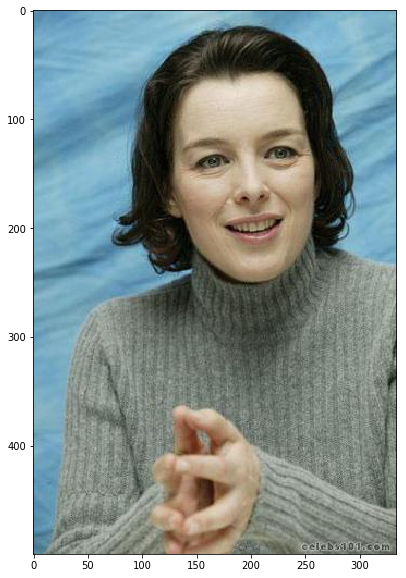

In [54]:
# 测试数据增强

import matplotlib.pyplot as plt

img = cv2.imread('000176.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = aug_pipe.augment_image(img)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [38]:
predictor_path = 'models/shape_predictor_5_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

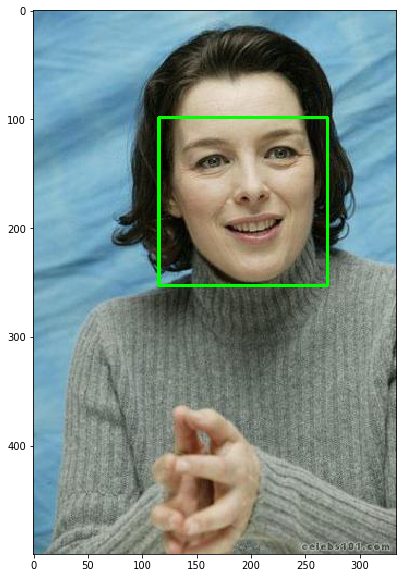

In [95]:
# ex: find a face and draw a rectangle

img = cv2.imread('000176.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dets = detector(img, 1)
for indx, face in enumerate(dets):
    left, right = face.left(), face.right()
    top, bottom = face.top(), face.bottom()
    cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)
    
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

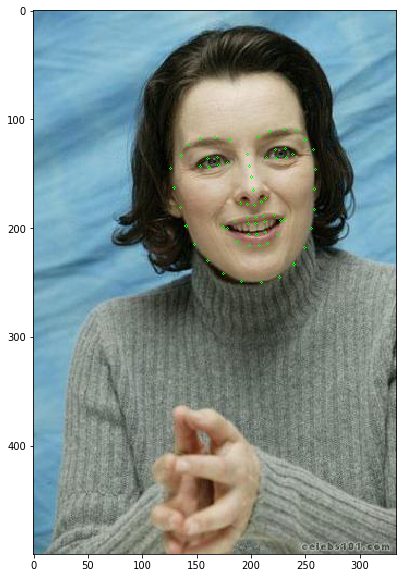

In [98]:
predictor_path = 'models/shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

img = cv2.imread('000176.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dets = detector(img, 1)
for indx, face in enumerate(dets):
    shape = predictor(img, face)
#     print(shape)
#     print(shape.num_parts)
    for ix, pt in enumerate(shape.parts()):
        pt_pos = (pt.x, pt.y)
        cv2.circle(img, pt_pos, 1, (0, 255, 0), 1)
    
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

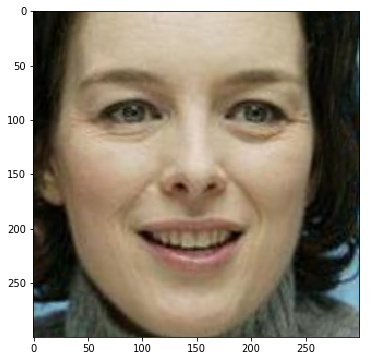

In [110]:
img = cv2.imread('000176.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dets = detector(img, 1)
faces = dlib.full_object_detections()
for det in dets:
    faces.append(predictor(img, det))
    
images = dlib.get_face_chips(img, faces, size=300)

fig = plt.figure(figsize=(6, 6))
plt.imshow(images[0])
plt.show()